<div style="text-align:center">
    <h1>
        Deep SARSA
    </h1>
</div>

<br><br>

<div style="text-align:center">

In this notebook, we extend the SARSA algorithm to use function approximators (Neural Networks). The resulting algorithm is known as Deep SARSA.
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 8 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import random
import copy
import gym #to create control task interfaces
import torch # to allow us to work with NN
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn as nn #main class of NN
from torch.optim import AdamW  # Adam is simply a modification of the SGD update rule that we've seen but with some modifications
                                # to make it more efficient
    
from tqdm import tqdm  #Cos NN usually take time to complete. tqdm allows us to see the progress bar to see how much time isleft
from utils import plot_cost_to_go, plot_max_q, test_agent, plot_stats, seed_everything

%matplotlib notebook  # to allow us to work with interactive plots 

UsageError: unrecognized arguments: # to allow us to work with interactive plots


## Create and prepare the environment

### Create the environment

In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env) #to make sure that any random numbers stay the same every time we run the notebook

In [3]:
#observe the # of dim and actions
state_dims = env.observation_space.shape[0] # first element in the tuple is the # of dims
num_actions = env.action_space.n

print(f"MountainCar env: State dimensions: {state_dims}, Number of actions: {num_actions}")

MountainCar env: State dimensions: 2, Number of actions: 3


In [ ]:
#dims = 2 ie [position, velocity] and num_action = 3 ie 0=move left, 1= do nothing, 2=move forward

### Prepare the environment to work with PyTorch

In [ ]:
""" To prepare our environment so that the PyTorch Library can easily work with it and will do that by creating an object 
that will wrap the environment and will give us the possibility to modify each of the elements that come out of the environment.

What this means is that, to execute an action in the environment, we'll first pass it to this wrapper class that will prepare 
it to be sent to the environment. And the elements that result from executing that action will be preprocessed by this class 
before we get them back. This class will inherit from another class, from the gym library called wrapper."""

In [4]:
class PreprocessEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    #override = Wraps env.reset
    def reset(self):
        state =  self.env.reset()
        
        #reshape the state to work with the batch of states/experiences instead of individual observations
        #[0., 0.] = [[0., 0.], [ 1., 1.]] (N x D) N= #of observation, D = #of dim (N=2, D=2 in this case exple)
        # For the actions [[1], [2]] will have the shape (2, 1) coz 2 actions of 1 dim
        return torch.from_numpy(state).unsqueeze(dim=0).float()
        
    
    #override = env.step
    def step(self, action):
         # It'll do 2 things, take the action that the NN produces and convert it to pytorch integer
            action = action.item()
            next_state, reward, done, info = self.env.step(action)
            # convert these values to tensor and prepare them to be able to include in the batches of data
            
            next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
            
            #batch of rewards need to have this shape [[0., 0.], [ 1., 1.]], [[1], [2]] (2, 1) so that the first elt of the
            # batch will be associated with the firt elt of the action batch and with the 1st elt of the state batch
            
            reward = torch.tensor(reward).view(1, -1).float() #[[0.]] is give extra inner dim to the reward. 
            done =  torch.tensor(done).view(1, -1)
            
            return next_state, reward, done, info
            
    
        

In [5]:
env = PreprocessEnv(env)

In [6]:
#check the elts produced by the wrapper

state =  env.reset()
action = torch.tensor(0) #action 0
next_state, reward, done, _ = env.step(action)
print(f"Sample state: {state}")
print(f"Next state: {next_state}, Reward: {reward}, Done: {done}")

Sample state: tensor([[-0.5252,  0.0000]])
Next state: tensor([[-0.5262, -0.0010]]), Reward: tensor([[-1.]]), Done: tensor([[False]])


In [ ]:
# we see the reward came with two extra dims so that the result can be included in bacthes. Same with the Done variable

## Create the Q-Network and policy

<br><br>

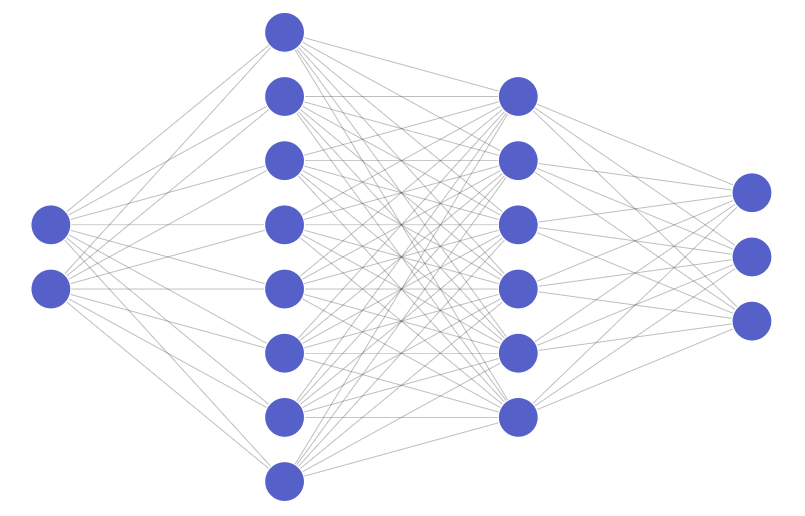

### Create the Q-Network: $\hat q(s,a| \theta)$

In [7]:
q_network =  nn.Sequential(
    #To first hidden layer
    # nn.Linear state * W + b
    nn.Linear(state_dims, 128), # 128 is the size of the 1st hidden layer we choose
    # nn.Relu = max(0, state * W + b )
    nn.ReLU(), #break the linearity
    
    # To second hidden layer
    nn.Linear(128, 64), # we dicide that the second hidden layer has 64 neurons
    nn.ReLU(), #break the linearity
    
    #To Output layer
    nn.Linear(64, num_actions) # return num_actions ie an estimate of the action-value

)

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [8]:
#this will be used to estimate the target value. Its parameters will not change during the learning process. It will be used
# only to compute the target value of the update rule

target_q_network = copy.deepcopy(q_network) # deepcopy copies the object and all its elts
target_q_network= target_q_network.eval() # eval() to make sure its param does not change

In [9]:
target_q_network

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [10]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach() #[[q1, q2, q3],[q1, q2, q3]]
        return torch.argmax(av, dim=-1, keepdim=True)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

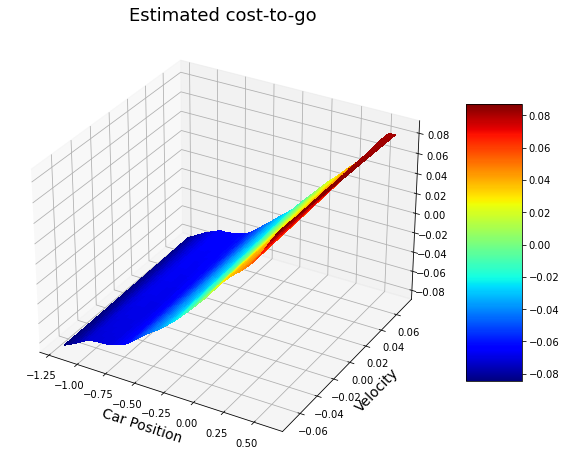

In [11]:
# Negative of the highest q-value of every state known as the Cost to Go ie the cost to reach the goal starting at each state

plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

In [ ]:
""" The neural network has been initialized randomly, which means that these predictions are not precise at all.
They are simply random values that will change during the learning process to reflect the optimal values."""

## Create the Experience Replay buffer

<br>
<div style="text-align:center">
    <p>A simple buffer that stores transitions of arbitrary values, adapted from
    <a href="https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training">this source.</a></p>
</div>

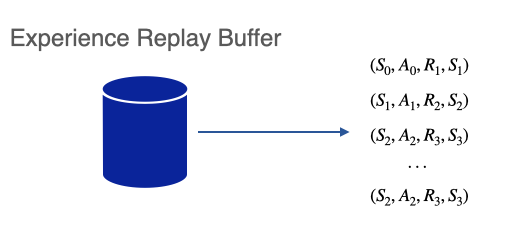


In [12]:
class ReplayMemory:
    def __init__(self, capacity=1000000):
        self.capacity =  capacity
        self.memory = []
        self.position = 0 #position where we have to store the next transition
        
        
    #insert. [s, a, r, s'] to insert the state transition
    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] =  transition
        self.position = (self.position + 1) % self.capacity
        
    
    #sample [[s, a, r, s'], [s, a, r, s']] to sample batch of experiences from the memory that will be used to update the NN
    def sample(self, batch_size):
        assert self.can_sample(batch_size) # tell us if we have enough in the memory to extra this size
        
        batch = random.sample(self.memory, batch_size) # [[s, a, r, s'], [s, a, r, s'], [s, a, r, s']]
        #but we want something like this [[s, s, s], [a, a, a], [r, r, r] [s', s', s']]
        batch = zip(*batch) # the '*' will umpact all transitions and pair elts together from each list
        
        return [torch.cat(items) for items in batch] # N x D e.g assuming in the case of states [s,s,s] that we have 32 states, 
                                                        # it will (32, 2) coz a state has 2 dims
    
    
    #can_sample -> 
       #""" that will give us the boolean value True/False. True is the memory has enough state transitions to begin
       #drawing batches from it, otherwise it'll return false"""
    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10
    
    
    #__len__ to tell us how many elts this object contains
    def __len__(self):
        return len(self.memory)
    

## Implement the algorithm

</br></br>

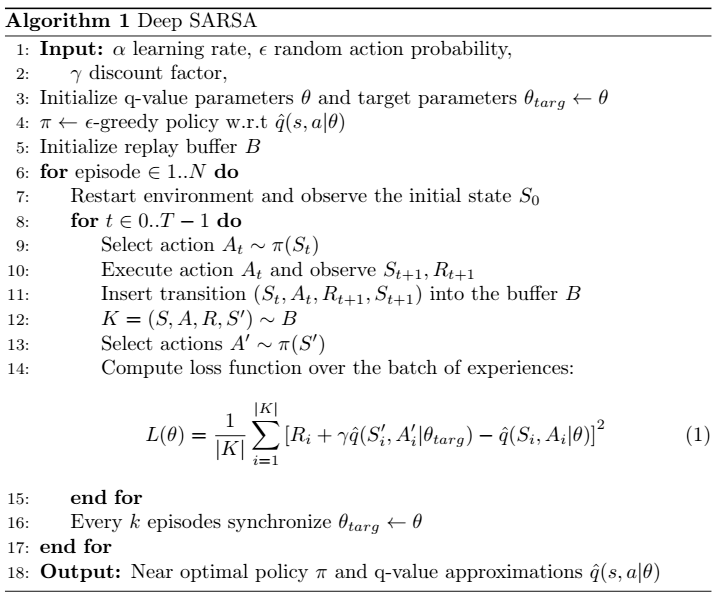

In [13]:
def deep_sarsa(q_network, policy, episodes, alpha=.001, batch_size=32, gamma=.99, epsilon=.05):
    #epsilon=.05 ie take a random action 5% of the time
    
    #initialie the instance of the object that will take care of applying the update rull to modify the para of the NN
    optim = AdamW(q_network.parameters(), lr=alpha) # AdamW is a small modification of the SGD
    
    #initialize the replay buffer
    memory = ReplayMemory(capacity=1000000)
    
    #initialize a dict of execution statistics
    stats = {'MSE Loss': [], 'Return': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state =  env.reset()
        done = False
        ep_return = 0. # keep track of the rewards in order to compute the Return,so that we can show it in our stats plot
        
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _  = env.step(action) # execute the action on the pytorch environment
            memory.insert([state, action, reward, done, next_state]) # insert into buffer B
            
            #update the NN
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                
                #compute the q-value with action_b that the agent chose
                qsa_b =  q_network(state_b).gather(1, action_b)
                #action that the policy (exploratory policy) picks for the state state
                next_action_b = policy(next_state_b, epsilon)
                #q-value of the target
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                #target value
                #target_b = reward_b + gamma * next_state_b
                
                 #however if the action performs by the agent took us to the goal, q-value of the next state will be zero
                    # so we need a little adjustment using the "done" value ie ~done_b or the opposite of Done
                target_b = reward_b + ~done_b *gamma * next_qsa_b
                
                #compute the cost function
                loss = F.mse_loss(qsa_b, target_b)
                
                #apply the update rule to the parameters of the NN
                q_network.zero_grad() #zero_grad() eliminate the grad that we have previously computed
                loss.backward() # kick oo the back propagation process to compute the gradient of the loss funct wrt each para
                optim.step() # to update the para of the NN
                
                stats['MSE Loss'].append(loss.item())
            
            state = next_state
            ep_return += reward.item()
            
        stats['Return'].append(ep_return) # store the return after each episode
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
    
    return stats

In [14]:
stats = deep_sarsa(q_network, policy, 1500, epsilon=0.01)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [20:50<00:00,  1.20it/s]


## Show results

### Plot execution stats

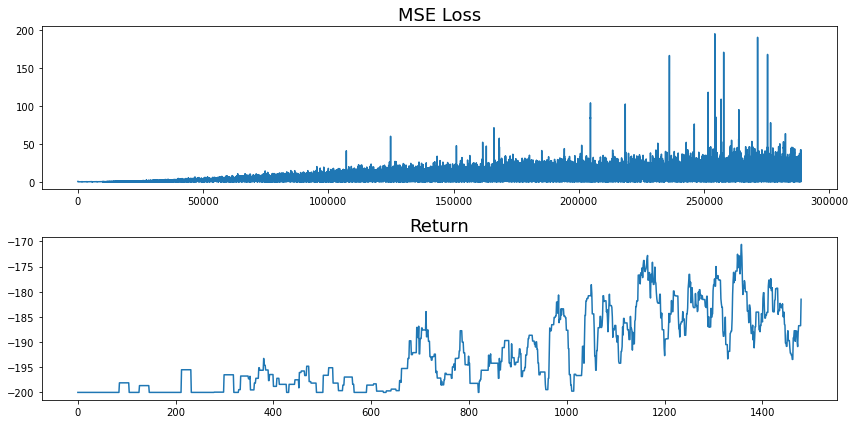

In [15]:
plot_stats(stats)

In [ ]:
# we can see at the begining that the agent gets very bad result with a return of -200, but at the end of learning process,
# it obtains the result of -120 ie it is capable of solving the task after 120 moves


### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

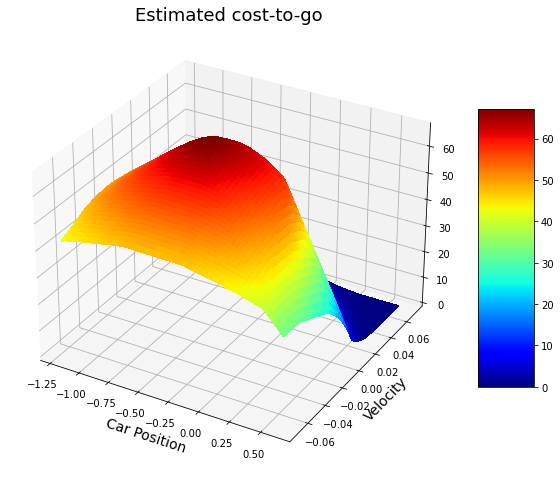

In [16]:
plot_cost_to_go(env, q_network, xlabel='Car Position', ylabel='Velocity')

In [ ]:
""" The state has the highest cost to go because the neural network estimates that it will take a long time 
to the agent to get to the goal from that state.
On the other hand, the state with the lowest cost to go is the state corresponding to the location of the flag.
That is when the car is at position zero point six."""

### Show resulting policy: $\pi(s)$

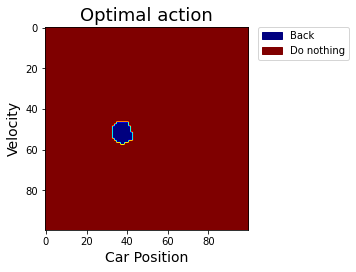

In [17]:
plot_max_q(env, q_network, xlabel='Car Position', ylabel='Velocity', 
           action_labels=['Back', 'Do nothing', 'Forward'])

### Test the resulting agent

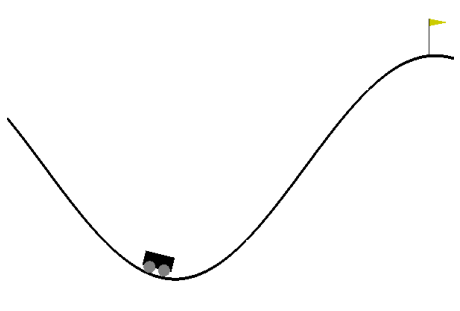

In [18]:
%matplotlib inline
test_agent(env, policy, episodes=2)

## Resources

[[1] Deep Reinforcement Learning with Experience Replay Based on SARSA](https://www.researchgate.net/publication/313803199_Deep_reinforcement_learning_with_experience_replay_based_on_SARSA)